In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/ai-platform-samples/blob/master/ai-platform-unified/notebooks/official/ml_metadata/sdk-metric-parameter-tracking-for-locally-trained-models.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/ai-platform-samples/blob/master/ai-platform-unified/notebooks/official/ml_metadata/sdk-metric-parameter-tracking-for-locally-trained-models.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

#Vertex AI: Track parameters and metrics for locally trained models

## Overview

This notebook demonstrates how to track metrics and parameters for ML training jobs and analyze this metadata using Vertex AI SDK.

### Dataset

In this notebook, we will train a simple distributed neural network (DNN) model to predict automobile's miles per gallon (MPG) based on automobile information in the [auto-mpg dataset](https://www.kaggle.com/devanshbesain/exploration-and-analysis-auto-mpg).

### Objective

In this notebook, you will learn how to use Vertex AI SDK to:

    * Track parameters and metrics for a locally trainined model.
    * Extract and perform analysis for all parameters and metrics within an Experiment.

### Costs 


This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage


Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Before you begin

### Select a GPU runtime

**Make sure you're running this notebook in a GPU runtime if you have that option. In Colab, select "Runtime --> Change runtime type > GPU"**

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

1. If you are running this notebook locally, you will need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [1]:
import os

PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Project ID:  jk-mlops-dev


Otherwise, set your project ID here.

In [2]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [3]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Authenticate your Google Cloud account

**If you are using AI Platform Notebooks**, your environment is already
authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.

**Otherwise**, follow these steps:

1. In the Cloud Console, go to the [**Create service account key**
   page](https://console.cloud.google.com/apis/credentials/serviceaccountkey).

2. Click **Create service account**.

3. In the **Service account name** field, enter a name, and
   click **Create**.

4. In the **Grant this service account access to project** section, click the **Role** drop-down list. Type "AI Platform"
into the filter box, and select
   **AI Platform Administrator**. Type "Storage Object Admin" into the filter box, and select **Storage Object Admin**.

5. Click *Create*. A JSON file that contains your key downloads to your
local environment.

6. Enter the path to your service account key as the
`GOOGLE_APPLICATION_CREDENTIALS` variable in the cell below and run the cell.

In [4]:
import os
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

# If on Google Cloud Notebooks, then don't execute this code
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

if not IS_GOOGLE_CLOUD_NOTEBOOK:
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

### Import libraries and define constants

Import required libraries.

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from google.cloud import aiplatform
from tensorflow.python.keras import Sequential, layers
from tensorflow.python.lib.io import file_io

Define some constants

In [10]:
EXPERIMENT_NAME = "demo-experiment"  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}

If EXEPERIMENT_NAME is not set, set a default one below:

In [11]:
if EXPERIMENT_NAME == "" or EXPERIMENT_NAME is None:
    EXPERIMENT_NAME = "my-experiment-" + TIMESTAMP

## Concepts

To better understanding how parameters and metrics are stored and organized, we'd like to introduce the following concepts:


### Experiment
Experiments describe a context that groups your runs and the artifacts you create into a logical session. For example, in this notebook you create an Experiment and log data to that experiment.

### Run
A run represents a single path/avenue that you executed while performing an experiment. A run includes artifacts that you used as inputs or outputs, and parameters that you used in this execution. An Experiment can contain multiple runs. 

## Getting started tracking parameters and metrics

You can use the Vertex AI SDK to track metrics and parameters for models trained locally. 

In the following example, you train a simple distributed neural network (DNN) model to predict automobile's miles per gallon (MPG) based on automobile information in the [auto-mpg dataset](https://www.kaggle.com/devanshbesain/exploration-and-analysis-auto-mpg).

### Load and process the training dataset

Download and process the dataset.

In [12]:
def read_data(file_path):
    column_names = [
        "MPG",
        "Cylinders",
        "Displacement",
        "Horsepower",
        "Weight",
        "Acceleration",
        "Model Year",
        "Origin",
    ]
    with file_io.FileIO(file_path, "r") as f:
        raw_dataset = pd.read_csv(
            f,
            names=column_names,
            na_values="?",
            comment="\t",
            sep=" ",
            skipinitialspace=True,
        )
    dataset = raw_dataset.dropna()
    dataset["Origin"] = dataset["Origin"].map(
        lambda x: {1: "USA", 2: "Europe", 3: "Japan"}.get(x)
    )
    dataset = pd.get_dummies(dataset, prefix="", prefix_sep="")
    return dataset


dataset = read_data("gs://cloud-samples-data/ai-platform/auto_mpg/auto-mpg.data")

Split dataset for training and testing.

In [13]:
def train_test_split(dataset, split_frac=0.8, random_state=0):
    train_dataset = dataset.sample(frac=split_frac, random_state=random_state)
    test_dataset = dataset.drop(train_dataset.index)
    train_labels = train_dataset.pop("MPG")
    test_labels = test_dataset.pop("MPG")

    return train_dataset, test_dataset, train_labels, test_labels


train_dataset, test_dataset, train_labels, test_labels = train_test_split(dataset)

Normalize the features in the dataset for better model performance.

In [14]:
def normalize_dataset(train_dataset, test_dataset):
    train_stats = train_dataset.describe()
    train_stats = train_stats.transpose()

    def norm(x):
        return (x - train_stats["mean"]) / train_stats["std"]

    normed_train_data = norm(train_dataset)
    normed_test_data = norm(test_dataset)

    return normed_train_data, normed_test_data


normed_train_data, normed_test_data = normalize_dataset(train_dataset, test_dataset)

### Define ML model and training function

In [15]:
def train(
    train_data,
    train_labels,
    num_units=64,
    activation="relu",
    dropout_rate=0.0,
    validation_split=0.2,
    epochs=1000,
):

    model = Sequential(
        [
            layers.Dense(
                num_units,
                activation=activation,
                input_shape=[len(train_dataset.keys())],
            ),
            layers.Dropout(rate=dropout_rate),
            layers.Dense(num_units, activation=activation),
            layers.Dense(1),
        ]
    )

    model.compile(loss="mse", optimizer="adam", metrics=["mae", "mse"])
    print(model.summary())

    history = model.fit(
        train_data, train_labels, epochs=epochs, validation_split=validation_split
    )

    return model, history

### Initialize the Model Builder SDK and create an Experiment

Initialize the *client* for Vertex AI and create an experiment.

In [16]:
aiplatform.init(project=PROJECT_ID, location=REGION, experiment=EXPERIMENT_NAME)

INFO:root:Resource demo-experiment not found.
INFO:root:Creating Resource demo-experiment


### Start several model training runs

Training parameters and metrics are logged for each run.

In [17]:
parameters = [
    {"num_units": 16, "epochs": 3, "dropout_rate": 0.1},
    {"num_units": 16, "epochs": 10, "dropout_rate": 0.1},
    {"num_units": 16, "epochs": 10, "dropout_rate": 0.2},
    {"num_units": 32, "epochs": 10, "dropout_rate": 0.1},
    {"num_units": 32, "epochs": 10, "dropout_rate": 0.2},
]

for i, params in enumerate(parameters):
    aiplatform.start_run(run=f"auto-mpg-local-run-{i}")
    aiplatform.log_params(params)
    model, history = train(
        normed_train_data,
        train_labels,
        num_units=params["num_units"],
        activation="relu",
        epochs=params["epochs"],
        dropout_rate=params["dropout_rate"],
    )
    aiplatform.log_metrics(
        {metric: values[-1] for metric, values in history.history.items()}
    )

    loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
    aiplatform.log_metrics({"eval_loss": loss, "eval_mae": mae, "eval_mse": mse})

INFO:root:Resource demo-experiment-auto-mpg-local-run-0 not found.
INFO:root:Creating Resource demo-experiment-auto-mpg-local-run-0
INFO:root:Resource demo-experiment-auto-mpg-local-run-0-metrics not found.
INFO:root:Creating Resource demo-experiment-auto-mpg-local-run-0-metrics
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 449
Trainable params: 449
Non-trainable params: 0
__________________________________________

### Extract parameters and metrics into a dataframe for analysis

We can also extract all parameters and metrics associated with any Experiment into a dataframe for further analysis.

In [18]:
experiment_df = aiplatform.get_experiment_df()
experiment_df

,experiment_name,run_name,param.dropout_rate,param.num_units,param.epochs,metric.loss,metric.mse,metric.val_mae,metric.eval_mse,metric.eval_mae,metric.val_mse,metric.mae,metric.val_loss,metric.eval_loss
0,demo-experiment,auto-mpg-local-run-4,0.2,32.0,10.0,412.549286,412.549286,18.261265,419.925720,18.480808,411.617493,18.362974,411.617493,419.925720
1,demo-experiment,auto-mpg-local-run-3,0.1,32.0,10.0,282.863037,282.863037,14.026794,270.131073,14.813652,249.740753,15.146656,249.740753,270.131073
2,demo-experiment,auto-mpg-local-run-2,0.2,16.0,10.0,406.859894,406.859894,18.527601,431.879395,18.879585,415.098053,18.356678,415.098053,431.879395
3,demo-experiment,auto-mpg-local-run-1,0.1,16.0,10.0,519.320862,519.320862,21.576517,554.939514,22.056217,530.097412,21.385426,530.097412,554.939514
4,demo-experiment,auto-mpg-local-run-0,0.1,16.0,3.0,551.268066,551.268066,22.563068,582.509033,22.820850,567.485718,22.226725,567.485718,582.509033


### Visualizing an experiment's parameters and metrics

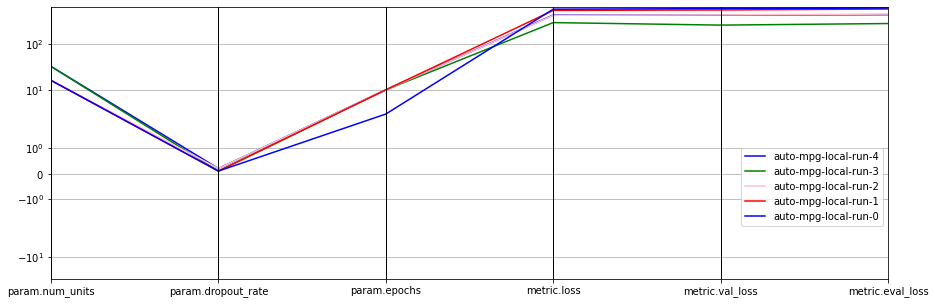

In [19]:
plt.rcParams["figure.figsize"] = [15, 5]

ax = pd.plotting.parallel_coordinates(
    experiment_df.reset_index(level=0),
    "run_name",
    cols=[
        "param.num_units",
        "param.dropout_rate",
        "param.epochs",
        "metric.loss",
        "metric.val_loss",
        "metric.eval_loss",
    ],
    color=["blue", "green", "pink", "red"],
)
ax.set_yscale("symlog")
ax.legend(bbox_to_anchor=(1.0, 0.5))

## Visualizing experiments in Cloud Console

Run the following to get the URL of Vertex AI Experiments for your project.


In [20]:
print("Vertex AI Experiments:")
print(
    f"https://console.cloud.google.com/ai/platform/experiments/experiments?folder=&organizationId=&project={PROJECT_ID}"
)

Vertex AI Experiments:
https://console.cloud.google.com/ai/platform/experiments/experiments?folder=&organizationId=&project=jk-mlops-dev


## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.